In [1]:
import os
import sys
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime 
windowSize=10
epochs=50
verbose=False
train=True

## Trial on my stock price data

In [2]:
#based on: https://www.youtube.com/watch?v=c0k-YLQGKjY
#format:
##         X           Y
## [[[1],[2],[3],[4]] [5]

def df_to_windowed_df(dataframe,windowSize=3):
  data=dataframe.to_numpy()
  X=[]
  Y=[]
  
  for i in range(0,len(data)-windowSize):
    # nth=[[a[0],a[1]] for a in data[i:i+windowSize]]
    nth=[[a[1]] for a in data[i:i+windowSize]]
    # print(nth)
    X.append(nth)
    Y.append((data[i+windowSize])[1])
  
  return np.array(X),np.array(Y)
    
## history of tesla share prices
filepath="TSLA.csv"
df=pd.read_csv(filepath)

df.Date = pd.to_datetime(df.Date).astype('int64') / 10**9
X,Y=df_to_windowed_df(df,windowSize=windowSize)

In [3]:
def splitDataset(X,Y,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))
    valindex=round(X.shape[0]*(1-valsize))
    
    x_train=X[:threshold_index]
    y_train=Y[:threshold_index]
    
    x_val=X[threshold_index:valindex]
    y_val=Y[threshold_index:valindex]
    
    x_test=X[valindex:]
    y_test=Y[valindex:]
    
    return x_train,y_train,x_val,y_val,x_test,y_test

x_train_0,y_train_0,x_val_0,y_val_0,x_test_0,y_test_0=splitDataset(X,Y)

In [4]:
###Normalize the data!

def zscoreNorm_manual(inp,mean,std):
    return (inp-mean)/std

normalize=True
if normalize==True:
    # Order=2 makes it a minmax scaling operation (so that we can de-normalize later)
    # x_train=tf.keras.utils.normalize(x_train_0,axis=0,order=2)
    # y_train=tf.keras.utils.normalize(y_train_0,axis=0,order=2)

    # x_val=tf.keras.utils.normalize(x_val_0,axis=0,order=2)
    # y_val=tf.keras.utils.normalize(y_val_0,axis=0,order=2)

    # x_test=tf.keras.utils.normalize(x_test_0,axis=0,order=np.inf)
    # y_test=tf.keras.utils.normalize(y_test_0,axis=0,order=np.inf)
    
    unNormData={"xtrain":[np.mean(x_train_0,axis=0),np.std(x_train_0,axis=0)],"ytrain":[np.mean(y_train_0,axis=0),np.std(y_train_0,axis=0)],
                "xval":[np.mean(x_val_0,axis=0),np.std(x_val_0,axis=0)],"yval":[np.mean(y_val_0,axis=0),np.std(y_val_0,axis=0)],
                "xtest":[np.mean(x_test_0,axis=0),np.std(x_test_0,axis=0)],"ytest":[np.mean(y_test_0,axis=0),np.std(y_test_0,axis=0)]
                }
    
    
    x_train=zscoreNorm_manual(x_train_0,unNormData["xtrain"][0],unNormData["xtrain"][1])
    y_train=zscoreNorm_manual(y_train_0,unNormData["ytrain"][0],unNormData["ytrain"][1])
    
    x_val=zscoreNorm_manual(x_val_0,unNormData["xval"][0],unNormData["xval"][1])
    y_val=zscoreNorm_manual(y_val_0,unNormData["yval"][0],unNormData["yval"][1])
    
    x_test=zscoreNorm_manual(x_test_0,unNormData["xtest"][0],unNormData["xtest"][1])
    y_test=zscoreNorm_manual(y_test_0,unNormData["ytest"][0],unNormData["ytest"][1])



# OPTED TO DO MANUAL Z-SCALING NORMALIZATION HERE SO THAT I CAN REVERSE IT LATER ON;
# EVEN READING THE DOCS ON THE TF KERAS NORMALIZATION ABOVE IT SEEMED LIKE IT SHOULDVE BEEN WORKING
# BUT I COUDLNT REVERSE IT; SOMETHING WEIRD WAS GOING ON.

In [5]:
# THIS IS JUST TO VALIDATE THAT THE NORMALIZATION AND DENORMALIZATION PROCESS WORKS
if verbose:
    print(y_test_0[-4])
    print("mean",unNormData['ytest'][0],np.mean(y_test_0,axis=0))
    print("std",unNormData['ytest'][1],np.std(y_test_0,axis=0))
    print(y_test[-4])
    print(y_test[-4]*unNormData['ytest'][1]+unNormData['ytest'][0])

In [6]:
if verbose:
    print(tf.config.list_physical_devices())

In [7]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer((x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.LSTM(64,return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(64,return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(32))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8,'relu'))
model.add(tf.keras.layers.Dense(1,'linear'))


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 62,609
Trainable params: 62,609
Non-trainable params: 0
_________________________________________________________________


In [8]:
logspath=os.path.join('logs','model_init')
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(logspath,'training.log'), separator=',', append=False)
cp=tf.keras.callbacks.ModelCheckpoint(logspath,save_best_only=True)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

In [9]:
if train:
    #putting this here so we can blindly run the whole script and still get the plots without HAVING to train
    # each time. Bc we still access the 'model' via a load model command below.
    history=model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),callbacks=[cp,csv_logger],verbose=verbose)

Epoch 1/50
85/86 [============================>.] - ETA: 0s - loss: 0.1694

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 126ms/step - loss: 0.1687 - val_loss: 0.2285
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.0174

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 115ms/step - loss: 0.0174 - val_loss: 0.1556
Epoch 3/50
82/86 [===========================>..] - ETA: 0s - loss: 0.0121

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 117ms/step - loss: 0.0119 - val_loss: 0.1470
Epoch 4/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0102 - val_loss: 0.1494
Epoch 5/50
86/86 [==============================] - 1s 11ms/step - loss: 0.0100 - val_loss: 0.1700
Epoch 6/50
84/86 [============================>.] - ETA: 0s - loss: 0.0124

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 116ms/step - loss: 0.0124 - val_loss: 0.1399
Epoch 7/50
86/86 [==============================] - 1s 11ms/step - loss: 0.0083 - val_loss: 0.1495
Epoch 8/50
82/86 [===========================>..] - ETA: 0s - loss: 0.0102

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 113ms/step - loss: 0.0099 - val_loss: 0.1295
Epoch 9/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0078 - val_loss: 0.1329
Epoch 10/50
86/86 [==============================] - 1s 11ms/step - loss: 0.0088 - val_loss: 0.1301
Epoch 11/50
86/86 [==============================] - 1s 11ms/step - loss: 0.0073 - val_loss: 0.1303
Epoch 12/50
82/86 [===========================>..] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 118ms/step - loss: 0.0076 - val_loss: 0.1210
Epoch 13/50
86/86 [==============================] - ETA: 0s - loss: 0.0064

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 115ms/step - loss: 0.0064 - val_loss: 0.1150
Epoch 14/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0066

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 117ms/step - loss: 0.0069 - val_loss: 0.1106
Epoch 15/50
86/86 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.1160
Epoch 16/50
85/86 [============================>.] - ETA: 0s - loss: 0.0056

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 116ms/step - loss: 0.0056 - val_loss: 0.1054
Epoch 17/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.1257
Epoch 18/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0051

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 113ms/step - loss: 0.0051 - val_loss: 0.1012
Epoch 19/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0045

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 118ms/step - loss: 0.0045 - val_loss: 0.1001
Epoch 20/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0042

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 129ms/step - loss: 0.0044 - val_loss: 0.0991
Epoch 21/50
86/86 [==============================] - 1s 16ms/step - loss: 0.0058 - val_loss: 0.1055
Epoch 22/50
81/86 [===========================>..] - ETA: 0s - loss: 0.0074

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 120ms/step - loss: 0.0072 - val_loss: 0.0936
Epoch 23/50
86/86 [==============================] - ETA: 0s - loss: 0.0073

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 119ms/step - loss: 0.0073 - val_loss: 0.0875
Epoch 24/50
82/86 [===========================>..] - ETA: 0s - loss: 0.0056

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 118ms/step - loss: 0.0055 - val_loss: 0.0842
Epoch 25/50
82/86 [===========================>..] - ETA: 0s - loss: 0.0054

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 116ms/step - loss: 0.0054 - val_loss: 0.0811
Epoch 26/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 0.0837
Epoch 27/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0917
Epoch 28/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0042 - val_loss: 0.0825
Epoch 29/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0033

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 165ms/step - loss: 0.0034 - val_loss: 0.0790
Epoch 30/50
84/86 [============================>.] - ETA: 0s - loss: 0.0035

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 176ms/step - loss: 0.0036 - val_loss: 0.0782
Epoch 31/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0042

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 168ms/step - loss: 0.0041 - val_loss: 0.0766
Epoch 32/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0786
Epoch 33/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0040

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 162ms/step - loss: 0.0039 - val_loss: 0.0684
Epoch 34/50
86/86 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0710
Epoch 35/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0698
Epoch 36/50
86/86 [==============================] - ETA: 0s - loss: 0.0038

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 177ms/step - loss: 0.0038 - val_loss: 0.0662
Epoch 37/50
84/86 [============================>.] - ETA: 0s - loss: 0.0038

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 163ms/step - loss: 0.0038 - val_loss: 0.0618
Epoch 38/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0668
Epoch 39/50
86/86 [==============================] - 1s 16ms/step - loss: 0.0040 - val_loss: 0.0634
Epoch 40/50
86/86 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0621
Epoch 41/50
83/86 [===========================>..] - ETA: 0s - loss: 0.0037

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 13s 157ms/step - loss: 0.0037 - val_loss: 0.0612
Epoch 42/50
85/86 [============================>.] - ETA: 0s - loss: 0.0040

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 15s 175ms/step - loss: 0.0040 - val_loss: 0.0607
Epoch 43/50
86/86 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0621
Epoch 44/50
86/86 [==============================] - 1s 16ms/step - loss: 0.0043 - val_loss: 0.0628
Epoch 45/50
86/86 [==============================] - 1s 16ms/step - loss: 0.0046 - val_loss: 0.0625
Epoch 46/50
86/86 [==============================] - 1s 15ms/step - loss: 0.0050 - val_loss: 0.0645
Epoch 47/50
86/86 [==============================] - ETA: 0s - loss: 0.0037

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 14s 168ms/step - loss: 0.0037 - val_loss: 0.0543
Epoch 48/50
86/86 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0596
Epoch 49/50
86/86 [==============================] - 1s 15ms/step - loss: 0.0040 - val_loss: 0.0551
Epoch 50/50
86/86 [==============================] - 1s 15ms/step - loss: 0.0039 - val_loss: 0.0621


In [10]:
# this is just making sure we can access it
model=tf.keras.models.load_model(logspath)
log_data = pd.read_csv(os.path.join(logspath,'training.log'), sep=',', engine='python') #this loads up the history

In [11]:
train_predictions=model.predict(x_train).flatten()
yflat=y_train.flatten()

86/86 [==============================] - 2s 6ms/step


In [12]:
train_predictions=model.predict(x_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals':yflat})

if verbose:
    train_results

86/86 [==============================] - 0s 5ms/step


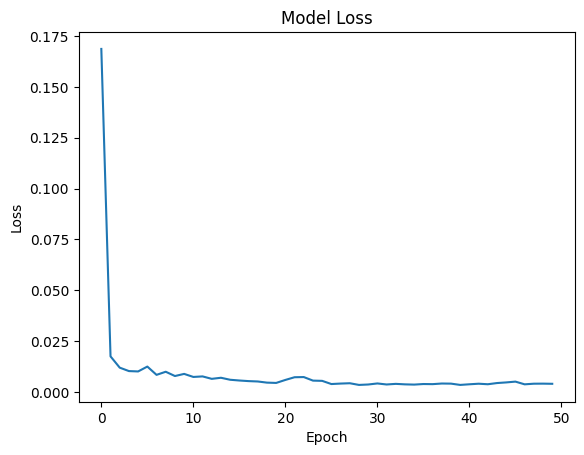

In [13]:
## Check for overfitting
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
## evaluate the model
testscore=model.evaluate(x_test,y_test)
if verbose: 
    print(testscore)

2/2 [==============================] - 1s 13ms/step - loss: 0.4057


In [15]:
# Add dates here because we arent training with the date becasue that is kind of annoying to do.
def genDateSplit(dates,windowSize,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))+windowSize
    valindex=round(X.shape[0]*(1-valsize))+windowSize
    
    a=dates[windowSize:threshold_index]
    b=dates[threshold_index:valindex]
    c=dates[valindex:]
    
    print(len(a),len(b),len(c))
    
    return a,b,c

unixdates=df.Date.tolist()
ndates=[]
for i in unixdates:
    ndates.append(datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%d'))
# print(ndates)

trainDates,val_dates,testDates=genDateSplit(ndates,windowSize)


2738 608 34


In [16]:
if verbose:
    # compare lengths of the data things
    print("train", len(trainDates),y_train.shape[0])
    print("val", len(val_dates),y_val.shape[0])
    print("test", len(testDates),y_test.shape[0])

In [17]:
new_x_set4Predict=np.concatenate((x_test[-1:,-9:,:],np.array([[y_test[-1]]]).reshape(1, 1, 1)),axis=1)

val_predictions=model.predict(x_val)
test_predictions=model.predict(x_test)
future_predict=model.predict(new_x_set4Predict)

1/1 [==============================] - 0s 28ms/step


In [18]:
## un-normalize data so that we can have the context to it
def unNormalize(normddata,meann,stddev):
    # print(meann,stddev)
    orig=normddata*stddev + meann
    return orig

normed_ytrain=unNormalize(y_train,unNormData['ytrain'][0],unNormData['ytrain'][1])
normed_yval=unNormalize(y_val,unNormData['yval'][0],unNormData['yval'][1])
normed_ytest=unNormalize(y_test,unNormData['ytest'][0],unNormData['ytest'][1])

normValPreedict=unNormalize(val_predictions,unNormData['yval'][0],unNormData['yval'][1])
normTestPredictions=unNormalize(test_predictions,unNormData['ytest'][0],unNormData['ytest'][1])
normed_futurePrediction=unNormalize(future_predict,unNormData['ytest'][0],unNormData['ytest'][1])


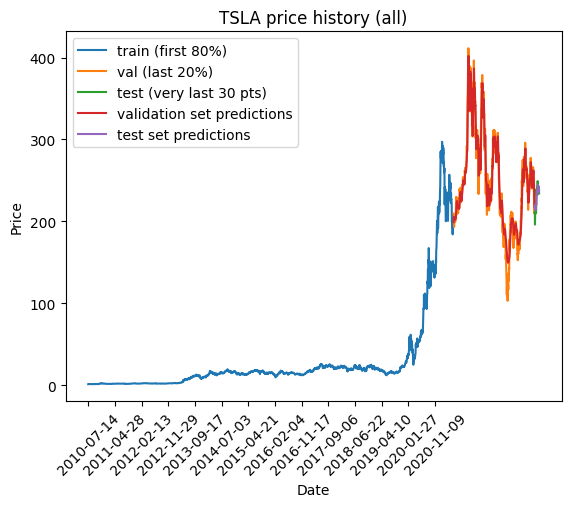

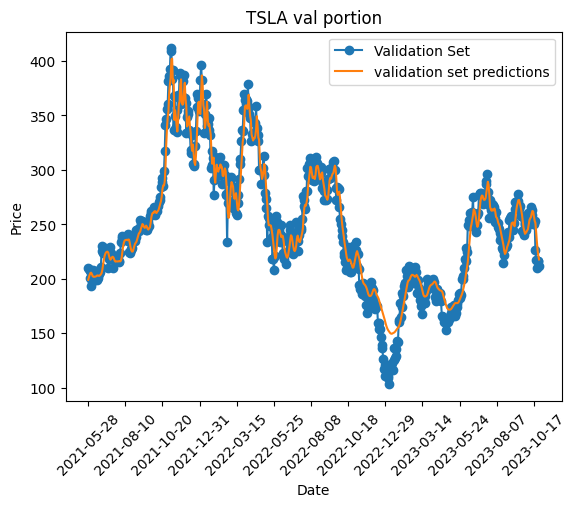

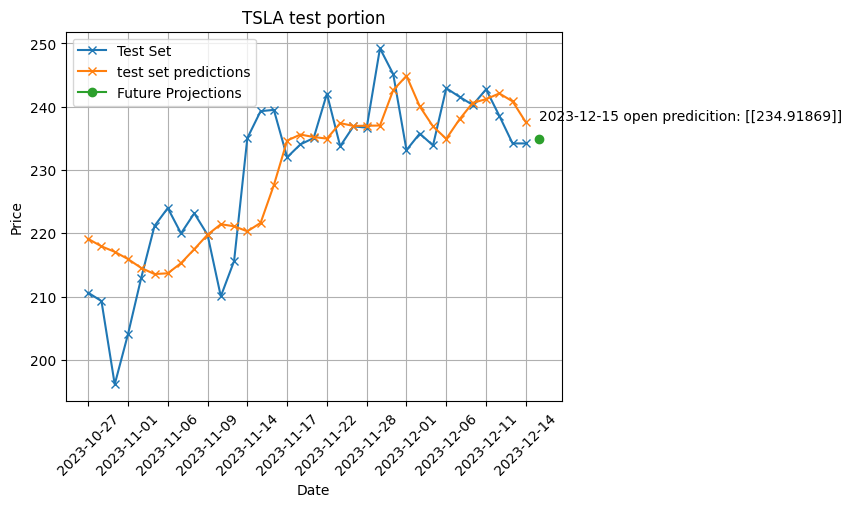

IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS


In [19]:
#Plot the real stock prices
plt.plot(trainDates,normed_ytrain.flatten(),label="train (first 80%)")
plt.xticks(trainDates[::200],rotation=45)
plt.plot(val_dates,normed_yval.flatten(),label="val (last 20%)")
plt.plot(testDates,normed_ytest.flatten(),label="test (very last 30 pts)")

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.plot(testDates,normTestPredictions,label="test set predictions")
plt.title('TSLA price history (all)')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(val_dates,normed_yval,label="Validation Set",marker='o')

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.xticks(val_dates[::50],rotation=45)
plt.title('TSLA val portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(testDates,normed_ytest,label="Test Set",marker='x')
plt.plot(testDates,normTestPredictions,label="test set predictions",marker='x')
futureDate=(datetime.datetime.strptime(testDates[-1],'%Y-%m-%d')+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
plt.plot(futureDate,normed_futurePrediction,label="Future Projections",marker='o')
plt.annotate(f"{futureDate} open predicition: {normed_futurePrediction}",[futureDate,normed_futurePrediction+3])
plt.xticks(testDates[::3],rotation=45)
plt.title('TSLA test portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()
plt.legend() 
plt.show()

print('IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS')
